In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Working on new docking oracles.

In [2]:
from dgym.envs.oracle import DockingOracle, NeuralOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'center_x': 44.294,
    'center_y': 28.123,
    'center_z': 2.617,
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
    'search_mode': 'balanced',
    'scoring': 'gnina',
    'seed': 5
}

docking_oracle = DockingOracle(
    'ADAM17 affinity',
    receptor_path=f'../../dgym-data/ADAM17.pdbqt',
    config=config
)

# create evaluators
docking_utility = ClassicUtilityFunction(
    docking_oracle,
    ideal=(8, 9.5),
    acceptable=(7.7, 9.5)
)

Other objectives.

In [61]:
import numpy as np
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.utility import ClassicUtilityFunction

# create evaluators
log_P_utility = ClassicUtilityFunction(
    RDKitOracle('MolLogP'),
    ideal=(1, 4),
    acceptable=(-0.5, 5.5)
)

log_S_utility = ClassicUtilityFunction(
    DGLOracle('GCN_canonical_ESOL'),
    ideal=(-2, 0),
    acceptable=(-4, 0.5)
)

# create utility function
def composite_utility_function(molecules):
    return (log_S_utility(molecules)**0.4) * (docking_utility(molecules)**0.6)

Run experiment.

In [63]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment
import numpy as np

# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck))
    initial_molecule = deck[initial_index]
    return initial_molecule

initial_molecule = select_molecule(deck)
while len(initial_molecule.reactants) != 2:
    initial_molecule = select_molecule(deck)

initial_library = dg.MoleculeCollection([initial_molecule]) # 659
initial_library.update_annotations()


# Set up experiment.
designer = Designer(
    Generator(building_blocks, fingerprints, sizes=sizes),
    reactions,
    cache = True
)

drug_env = DrugEnv(
    designer,
    library = initial_library,
    assays = [log_P_utility.oracle, log_S_utility.oracle, docking_utility.oracle],
    budget = 1_000,
    utility_function = composite_utility_function,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 10, 'strict': False}},
    {'name': 'ideate', 'parameters': {'temperature': 0.0, 'size': 10, 'strict': True}},
    {'name': 'ADAM17 affinity'},
    {'name': 'MolLogP'},
    {'name': 'GCN_canonical_ESOL'},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = composite_utility_function,
    exploration_strategy = EpsilonGreedy(epsilon = 0.0),
    branch_factor = 2
)

# Run experiment.
experiment = Experiment(drug_agent, drug_env)
result = experiment.run(1, progress=True)

  1%|▎                            | 12/1000 [00:03<04:59,  3.29it/s]

5.791482711499787



  4%|█▏                           | 40/1000 [00:22<08:46,  1.82it/s]

6.401324880838927
6.401324880838927
6.401324880838927
6.401324880838927



  5%|█▎                           | 46/1000 [00:46<20:32,  1.29s/it]

6.401324880838927



  7%|█▉                           | 66/1000 [00:59<14:52,  1.05it/s]

6.614894883418789
6.614894883418789
6.614894883418789
6.614894883418789



  9%|██▍                          | 86/1000 [01:01<09:02,  1.69it/s]

6.614894883418789



 11%|██▉                         | 106/1000 [01:15<09:27,  1.58it/s]

6.944255124856705
6.944255124856705
6.944255124856705
6.944255124856705
6.944255124856705



 13%|███▌                        | 126/1000 [01:50<14:49,  1.02s/it]

7.295983692584653
7.295983692584653
7.295983692584653
7.295983692584653



 15%|████                        | 146/1000 [01:50<09:47,  1.45it/s]

7.295983692584653



 17%|████▋                       | 166/1000 [02:05<09:49,  1.42it/s]

7.833702076023948
7.833702076023948
7.833702076023948
7.833702076023948
7.833702076023948



 19%|█████▏                      | 186/1000 [02:43<14:47,  1.09s/it]

7.833702076023948
7.833702076023948
7.833702076023948
7.833702076023948
7.833702076023948



 21%|█████▊                      | 206/1000 [03:24<18:16,  1.38s/it]

7.833702076023948
7.833702076023948
7.833702076023948
7.833702076023948



 21%|█████▉                      | 212/1000 [03:48<22:06,  1.68s/it]

7.833702076023948



 23%|██████▍                     | 232/1000 [04:04<17:33,  1.37s/it]

7.901796536360633
7.901796536360633
7.901796536360633
7.901796536360633
7.901796536360633



 25%|███████                     | 252/1000 [04:46<20:04,  1.61s/it]

7.901796536360633
7.901796536360633
7.901796536360633
7.901796536360633
7.901796536360633



 27%|███████▌                    | 272/1000 [05:23<20:34,  1.70s/it]

7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209



 28%|███████▉                    | 282/1000 [05:40<20:19,  1.70s/it]

7.992423284049209



 30%|████████▍                   | 302/1000 [05:58<16:26,  1.41s/it]

7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209



 30%|████████▍                   | 303/1000 [06:23<23:12,  2.00s/it]

7.992423284049209



 32%|█████████                   | 323/1000 [06:38<16:39,  1.48s/it]

7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209



 34%|█████████▌                  | 343/1000 [07:16<17:58,  1.64s/it]

7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209



 36%|██████████▏                 | 363/1000 [07:57<18:49,  1.77s/it]

7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209



 38%|██████████▋                 | 383/1000 [08:37<19:02,  1.85s/it]

7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209



 40%|███████████▎                | 403/1000 [09:17<18:54,  1.90s/it]

7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209



 42%|███████████▊                | 423/1000 [09:51<17:42,  1.84s/it]

7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209



 43%|███████████▉                | 426/1000 [10:18<21:49,  2.28s/it]

7.992423284049209



 45%|████████████▍               | 446/1000 [10:40<17:04,  1.85s/it]

7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209



 45%|████████████▋               | 452/1000 [11:05<19:46,  2.16s/it]

7.992423284049209



 47%|█████████████▏              | 472/1000 [11:15<13:16,  1.51s/it]

7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209



 47%|█████████████▏              | 473/1000 [11:40<18:45,  2.14s/it]

7.992423284049209



 49%|█████████████▊              | 493/1000 [11:54<12:51,  1.52s/it]

7.992423284049209
7.992423284049209
7.992423284049209
7.992423284049209



 49%|█████████████▊              | 494/1000 [12:19<18:52,  2.24s/it]

7.992423284049209



 51%|██████████████▍             | 514/1000 [12:36<12:46,  1.58s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 53%|██████████████▉             | 534/1000 [13:15<13:31,  1.74s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 54%|██████████████▉             | 535/1000 [13:40<18:20,  2.37s/it]

7.998383130058069



 56%|███████████████▌            | 555/1000 [13:55<12:19,  1.66s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 56%|███████████████▌            | 556/1000 [14:18<17:11,  2.32s/it]

7.998383130058069



 58%|████████████████▏           | 576/1000 [14:35<11:30,  1.63s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 60%|████████████████▋           | 596/1000 [15:14<11:45,  1.75s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 62%|█████████████████▏          | 616/1000 [15:56<12:00,  1.88s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 64%|█████████████████▊          | 636/1000 [16:40<12:02,  1.99s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 66%|██████████████████▎         | 656/1000 [17:21<11:32,  2.01s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 68%|██████████████████▉         | 676/1000 [18:06<11:17,  2.09s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 70%|███████████████████▍        | 696/1000 [18:48<10:33,  2.08s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 72%|████████████████████        | 716/1000 [19:29<09:52,  2.08s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 74%|████████████████████▌       | 736/1000 [20:11<09:08,  2.08s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 76%|█████████████████████▏      | 756/1000 [20:55<08:38,  2.13s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 78%|█████████████████████▋      | 776/1000 [21:36<07:49,  2.10s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 80%|██████████████████████▎     | 796/1000 [22:17<07:06,  2.09s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 82%|██████████████████████▊     | 816/1000 [22:59<06:23,  2.08s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 84%|███████████████████████▍    | 836/1000 [23:40<05:40,  2.08s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 86%|███████████████████████▉    | 856/1000 [24:19<04:52,  2.03s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 88%|████████████████████████▌   | 876/1000 [24:59<04:10,  2.02s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 90%|█████████████████████████   | 896/1000 [25:37<03:27,  1.99s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 92%|█████████████████████████▋  | 916/1000 [26:18<02:48,  2.01s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 94%|██████████████████████████▏ | 936/1000 [27:00<02:10,  2.04s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 96%|██████████████████████████▊ | 956/1000 [27:43<01:30,  2.07s/it]

7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069
7.998383130058069



 98%|███████████████████████████▎| 976/1000 [28:24<00:49,  2.07s/it]

8.149521766868293
8.149521766868293
8.149521766868293
8.149521766868293



 98%|███████████████████████████▎| 977/1000 [28:48<00:57,  2.52s/it]

8.149521766868293



100%|███████████████████████████▉| 997/1000 [29:02<00:05,  1.85s/it]

8.149521766868293
8.149521766868293
8.149521766868293
8.149521766868293
8.149521766868293



100%|███████████████████████████████| 1/1 [29:41<00:00, 1781.22s/it]
1017it [29:41,  1.75s/it]

8.149521766868293
8.149521766868293
8.149521766868293
8.149521766868293


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

annotated_molecules = drug_env.library
g = sns.boxplot(
    x = [a.design_cycle for a in annotated_molecules],
    y = docking_utility.oracle(annotated_molecules),
)

g.set_title('Affinity vs. design cycle | Greedy tree search')
g.set_xlabel('Design cycle')
g.set_ylabel('pIC50 (ADAM17)')

plt.gcf().set_dpi(150)
plt.show()

NameError: name 'drug_env' is not defined

In [106]:
pd.DataFrame(docking_utility.oracle(drug_env.library))

,0
0,5.791483
1,5.791483
2,5.721818
3,5.801793
4,5.786320
...,...
1011,7.184316
1012,7.667034
1013,7.088532
1014,6.950503


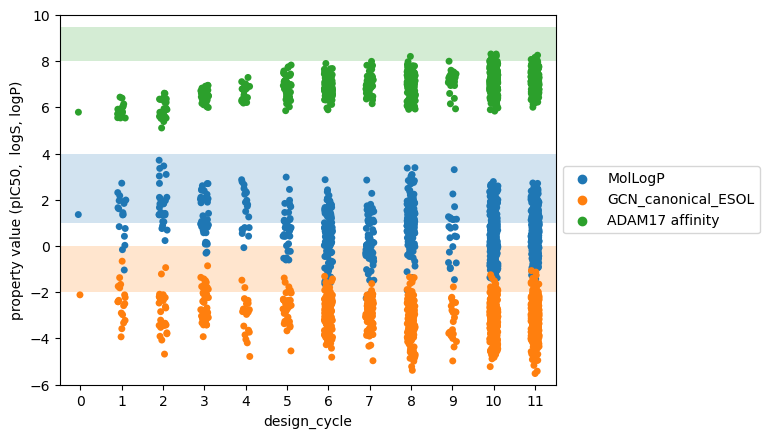

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

utility_fns = [log_P_utility, log_S_utility, docking_utility]

records = []
for utility_fn in utility_fns:
    scores = utility_fn.oracle(drug_env.library)
    for molecule, score in zip(drug_env.library, scores):
        records.append(
            {
                'design_cycle': molecule.design_cycle,
                'property value (pIC50,  logS, logP)': score,
                'assay': utility_fn.oracle.name
            }
        )
        
plt.fill_betweenx(log_P_utility.ideal, -1, 18, alpha=0.2, zorder=-10)
plt.fill_betweenx(log_S_utility.ideal, -1, 18, alpha=0.2, zorder=-10)
plt.fill_betweenx(docking_utility.ideal, -1, 18, alpha=0.2, zorder=-10)

g = sns.stripplot(
    pd.DataFrame(records),
    x='design_cycle',
    y='property value (pIC50,  logS, logP)',
    hue='assay',
)

# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.set_ybound(-6, 10)

In [66]:
library = drug_env.library

results = [
    library,
    log_P_utility.oracle(library),
    log_S_utility.oracle(library),
    docking_utility.oracle(library),
]

records = []
for mol, log_P, log_S, affinity in zip(*results):
    records.append(
        {
            'smiles': mol.smiles,
            'design cycle': mol.design_cycle,
            'log P': log_P,
            'log S': log_S,
            'ADAM17 pIC50': affinity
        }
    )

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


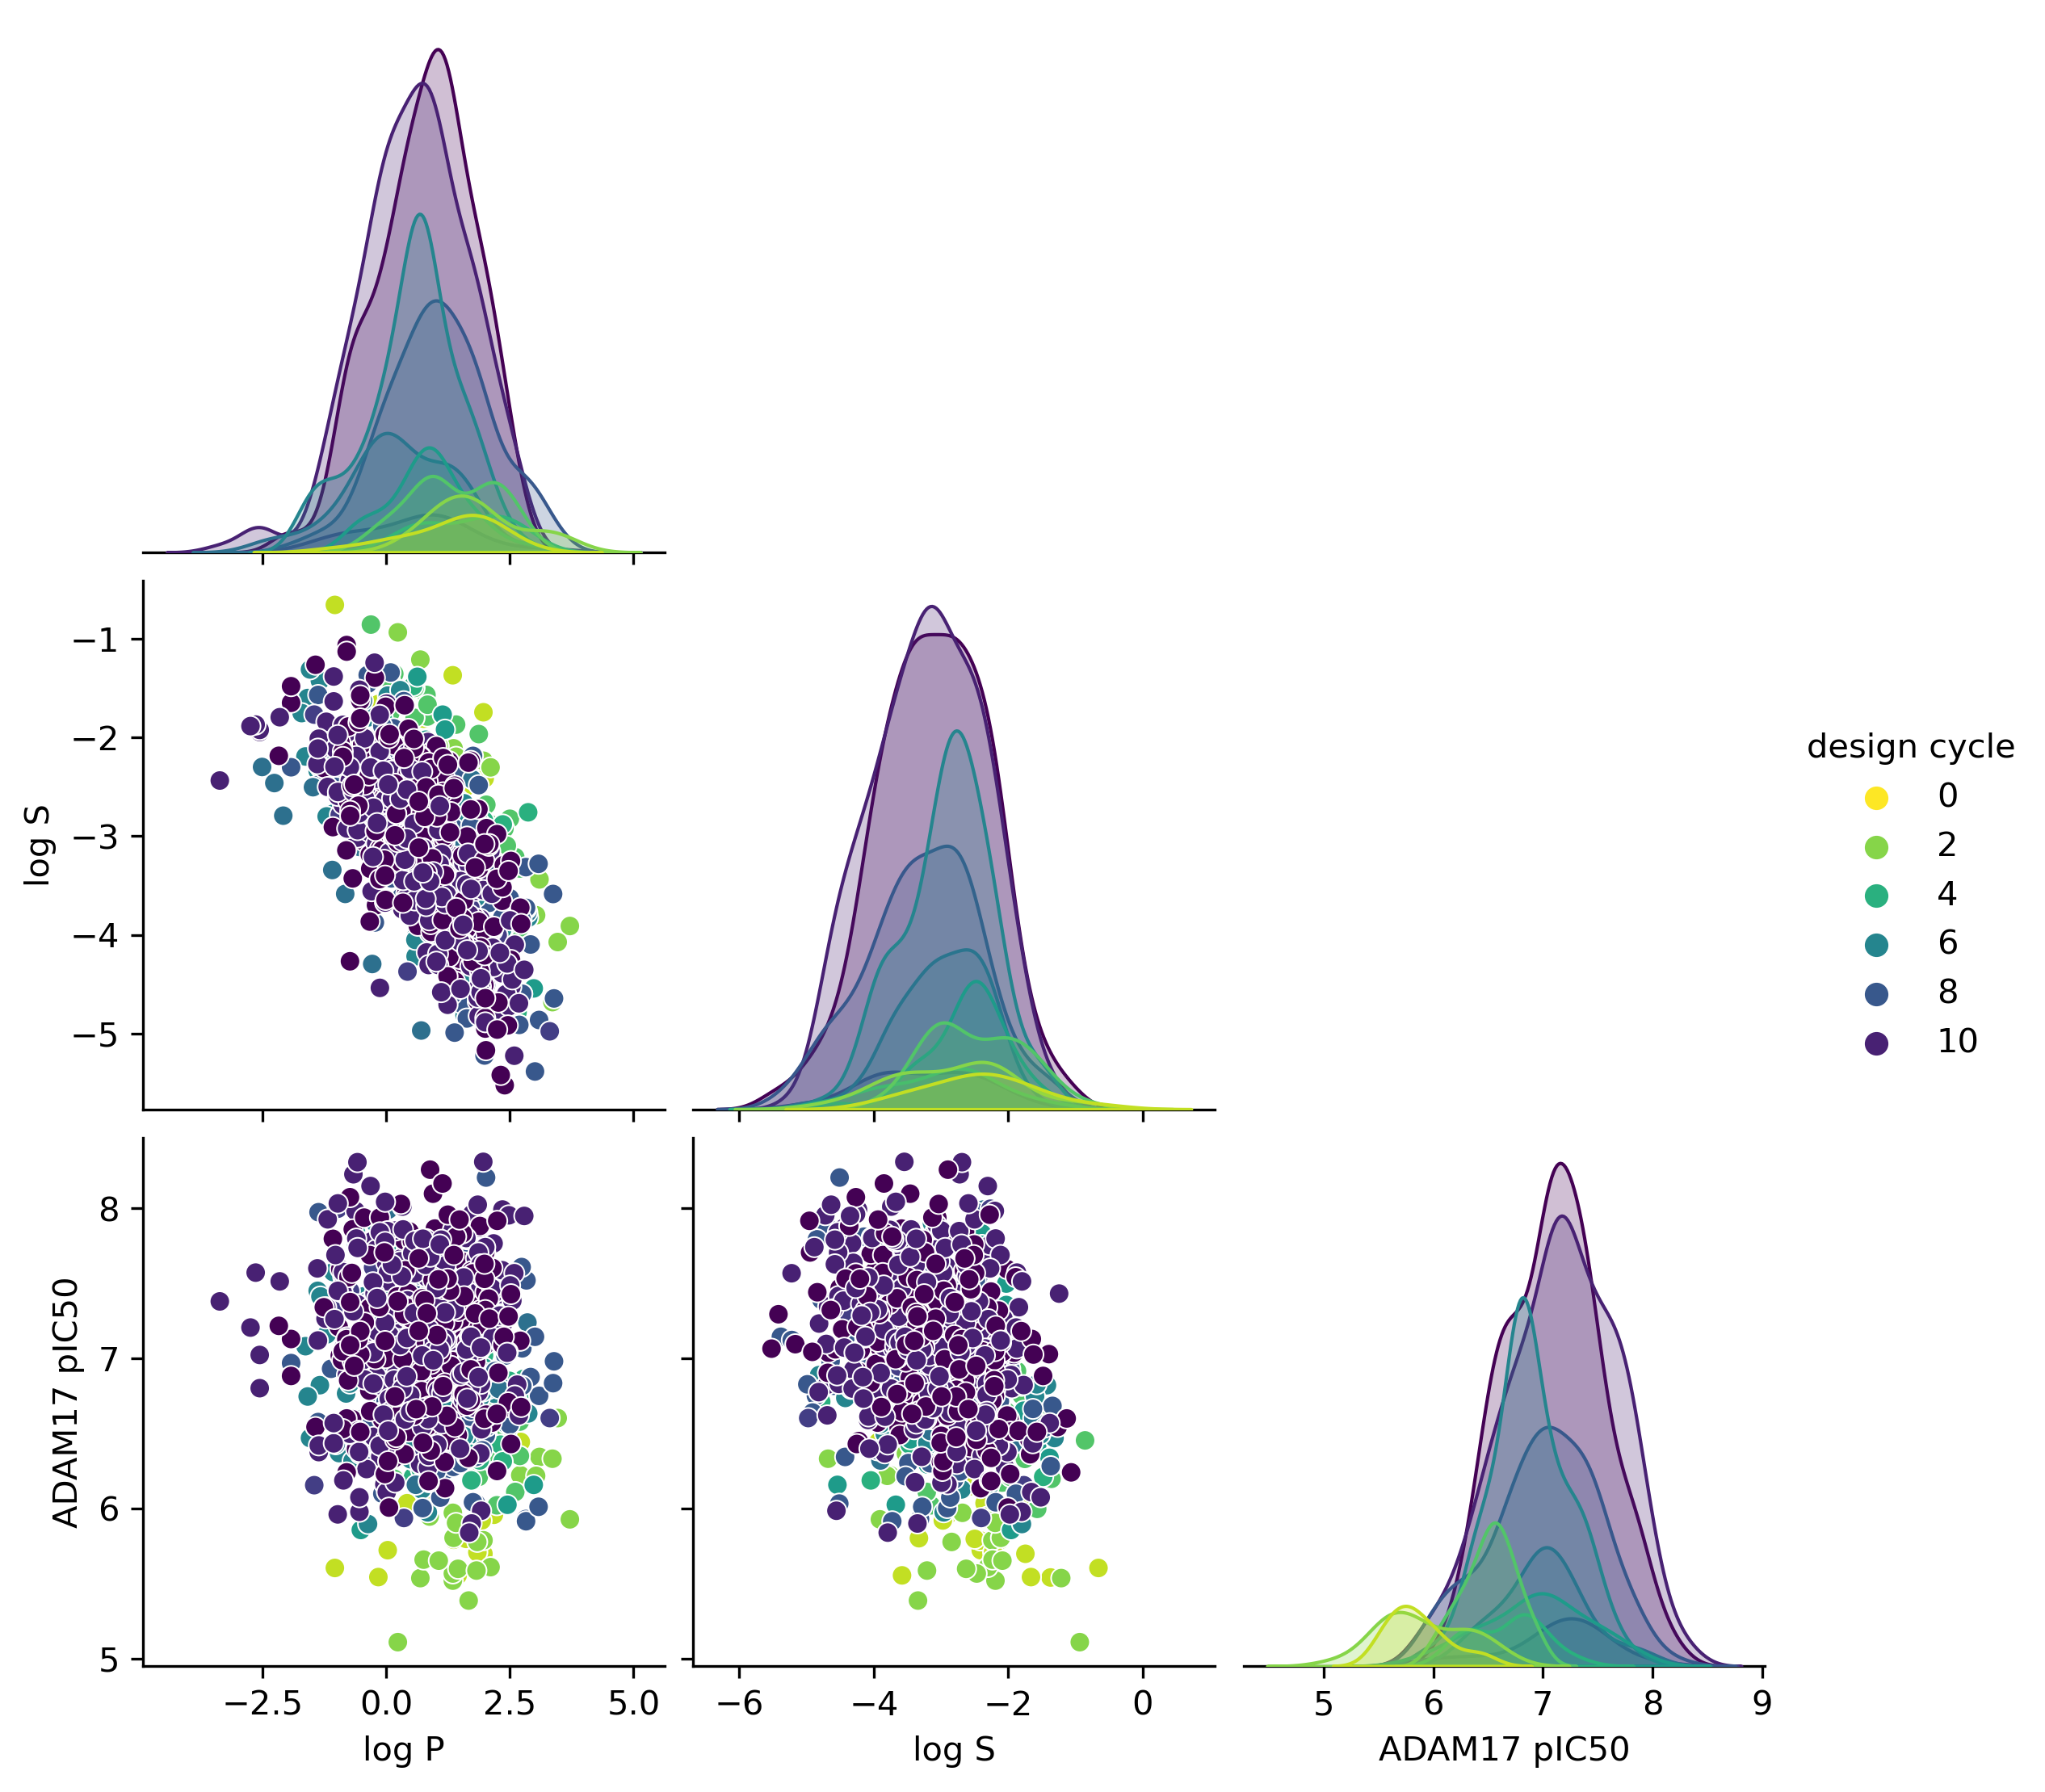

In [67]:
g = sns.pairplot(
    pd.DataFrame(records),
    vars=['log P', 'log S', 'ADAM17 pIC50'],
    hue='design cycle',
    corner=True,
    kind='scatter',
    palette='viridis_r'
)

g.fig.set_dpi(300)

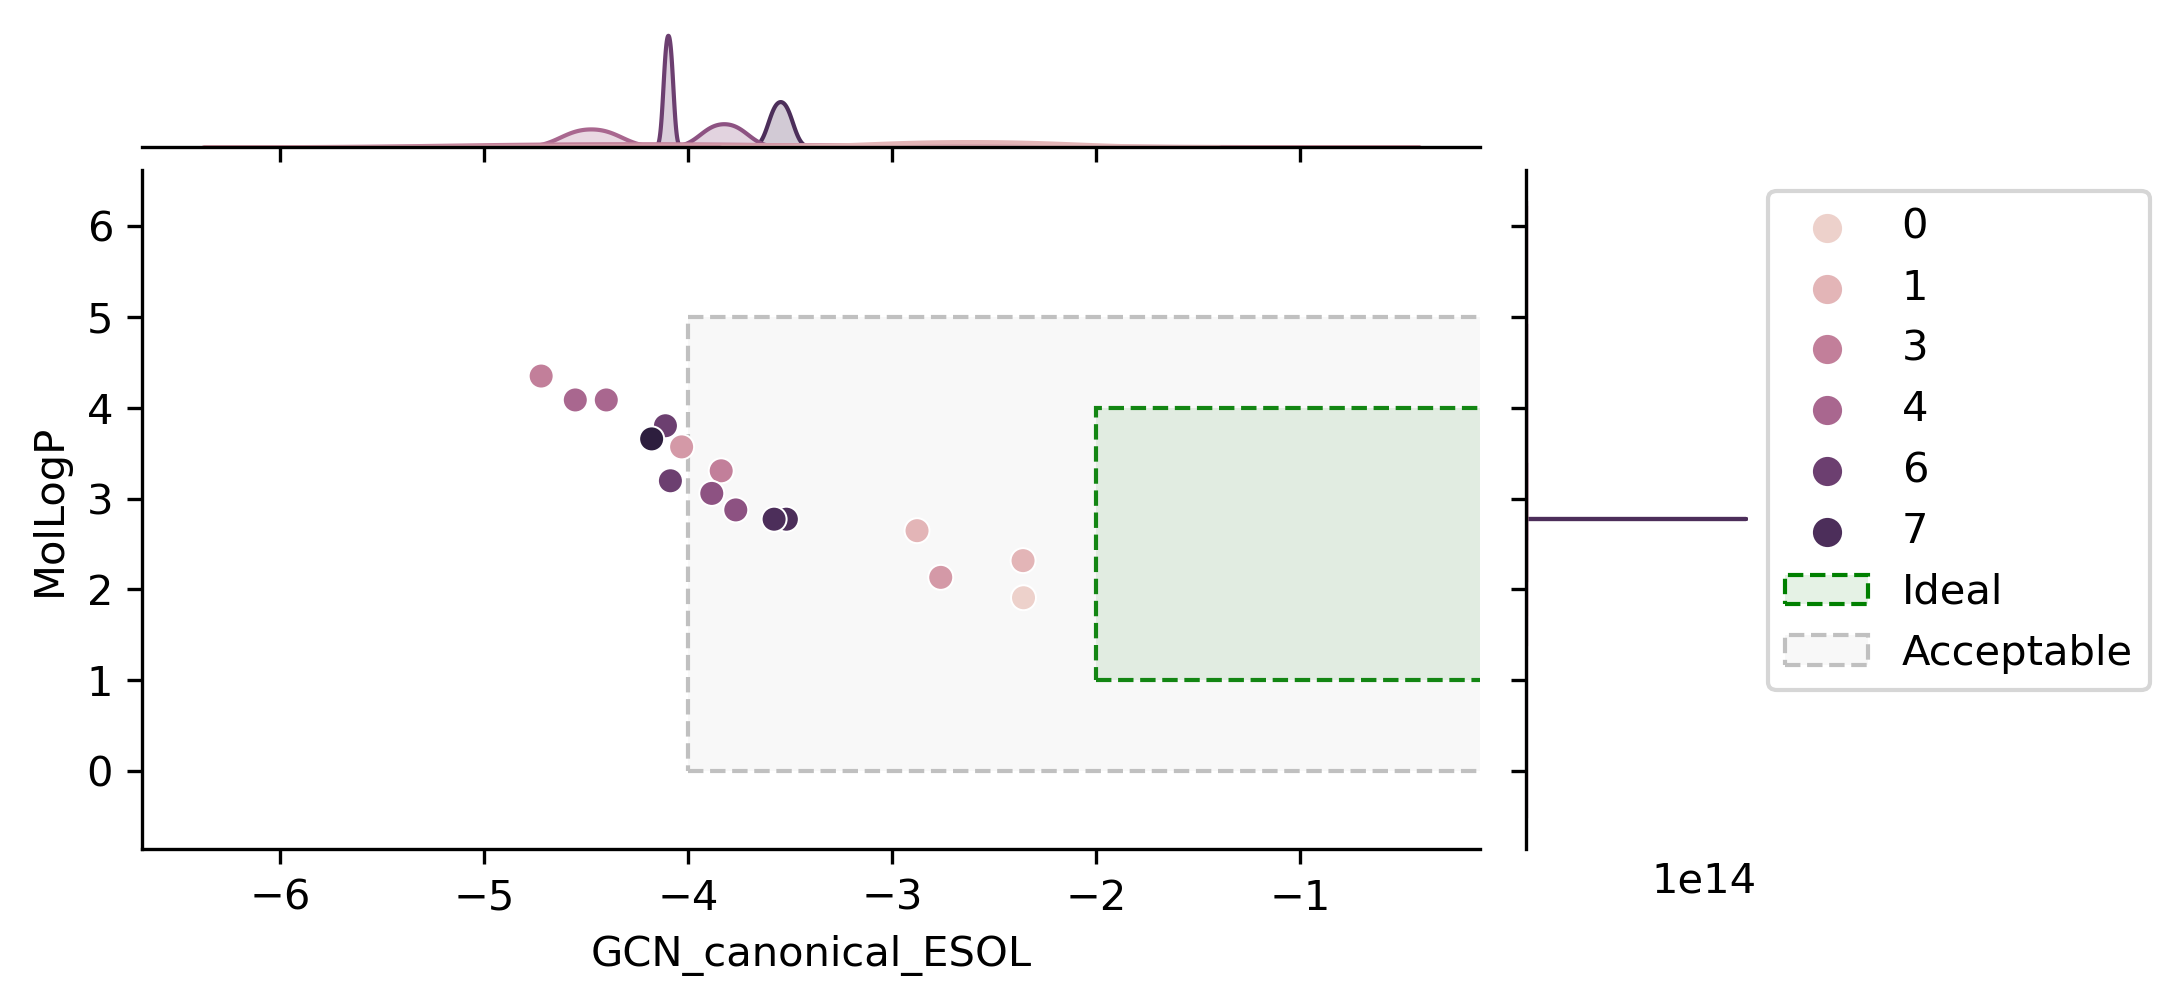

In [104]:
utility_fns = [log_S_utility, log_P_utility]

dg.plotting.plot(drug_env.library.annotated, utility_fns)